# Synthetic dataset creation

In this notebook I create a synthetic dataset to test the proposed bandit algorithm and compare it to benchmarks.
Synthetic dataset will have following features:
- 10,000 time points
- At each time $t$ the environment generates a context vector $x_t$ of dimension 10. Each feature $x_t^{(i)}$ is **categorical**. 
- Each context vector $x_t$ is associated with a cost vector $c_t$. Cost of each feature is $c_t^{i}$ is Gaussian with fixed standard deviation and **piecewise-stationary** mean lying in range $[0; 0.1]$. Change-points of costs are different from change points of rewards.
- A fixed (for all $t$) set $\mathcal{A}$ of 5 arms are available for the algorithm to choose from.
- Rewards associated with each arm and context follow a Bernoulli distribution, parametrized by $p = \sigma(x_t^T\theta_{t,a})$ where $\sigma()$ is the sigmoid function and $\theta_{t,a}$ is the ground truth bandit parameter (not disclosed to the algorithm) associated with each arm $a_i$ at time $t$. Bandit parameter satisfies condition $\lVert\theta_{t,a}\rVert_2 \le 1$.  Parameter $\theta_{t,a}$ is piecewise-stationary and thus the generated **rewards are piecewise-stationary** with change points every 2000 steps.
This method of generating rewards from contexts follows [1] and [2], but instead of Gaussian reward with mean $x_t^T\theta_{t,a}$ the reward is Bernoulli with parameter $\sigma(x_t^T\theta_{t,a})$

[1] Learning Contextual Bandits in a Non-stationary Environment, Wu et al.

[2] Contextual-Bandit Based Personalized Recommendation with Time-Varying User Interests, Xu et al.

In [1]:
import os
os.chdir('../..')
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [510]:
import numpy as np
import matplotlib.pyplot as plt

import costs
from plotting.costs import plot_costs

In [569]:
# Set random seeds for reproducibility
np.random.seed(42)

## Creating context vectors

In [512]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [513]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [514]:
feature_config = {
    0: {
        'values': [0,1,2,3],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [-2,-1,0,1],
        'distribution': [0.5, 0.2, 0.2, 0.1],
    },
    2: {
        'values': [5,6,7,8],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    3: {
        'values': [-5, -4,-3,-2,-1,0,1,2,3,4,5],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
    4: {
        'values': [0,1,2,3],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    5: {
        'values': [-2,-1,0,1],
        'distribution': [0.1, 0.4, 0.2, 0.3],
    },
    6: {
        'values': [7,8,9,10],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [-5, -4,-3,-2,-1,0,1,2,3,4,5],
        'distribution': [0.01, 0.03, 0.07, 0.11, 0.12, 0.14, 0.16, 0.20, 0.11, 0.04, 0.01],
    },
    8: {
        'values': [0,1,2,3],
        'distribution': [0.25]*4,
    },
    9: {
        'values': [-2,-1,0,1],
        'distribution': [0.3, 0.2, 0.4, 0.1],
    },
}

In [515]:
TIME_POINTS = 10000
NUM_FEATURES = 10

In [516]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [517]:
contexts, contexts.shape

(array([[ 3., -1.,  6., ..., -1.,  3.,  0.],
        [ 3., -2.,  7., ..., -1.,  2., -2.],
        [ 3., -1.,  6., ..., -1.,  0.,  0.],
        ...,
        [ 1., -2.,  6., ..., -1.,  0.,  0.],
        [ 0., -1.,  8., ...,  1.,  2.,  1.],
        [ 1.,  0.,  7., ...,  2.,  0.,  0.]]),
 (10000, 10))

### Visualizing context features

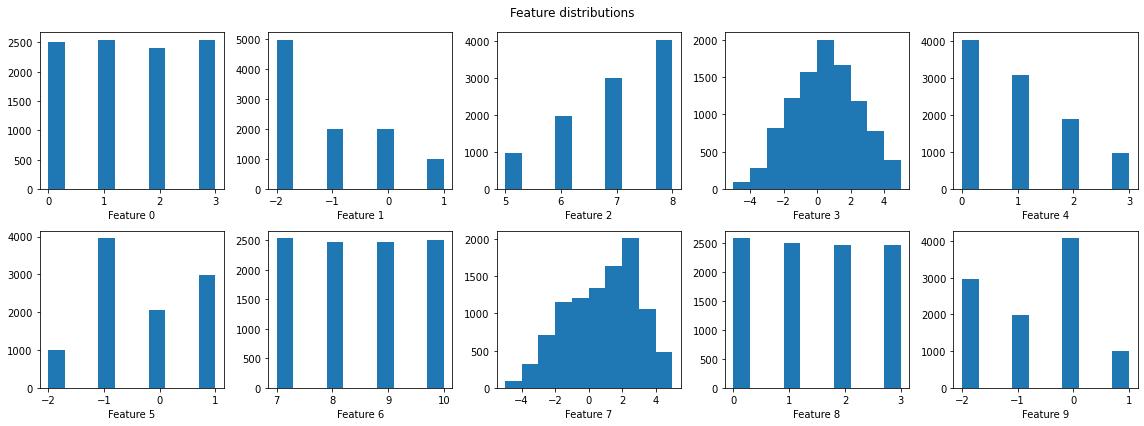

In [518]:
fig, axs = plt.subplots(2, NUM_FEATURES//2, figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating cost vectors

In [519]:
# Mean of gaussian distribution random in interval [0, 0.1]
interval_means = [np.random.uniform(0, 0.1, size=(NUM_FEATURES,)) for i in range(5)]

In [520]:
# Fixed std
interval_stds = [[0.001]*NUM_FEATURES]*5

In [521]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=NUM_FEATURES,
        change_points=[3000, 4500, 5500, 8000],
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

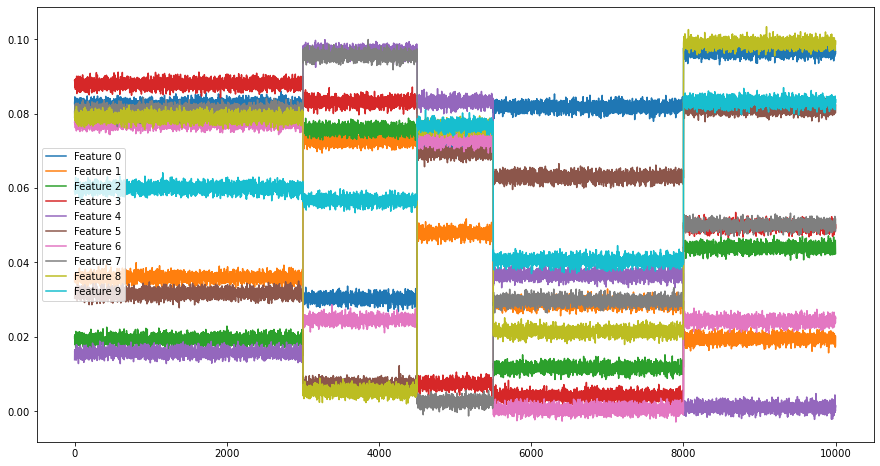

In [522]:
plot_costs(get_costs(), 10000)

In [523]:
costs_obj = get_costs()

In [524]:
costs_vector = []
for t in range(TIME_POINTS):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [525]:
costs_vector.shape

(10000, 10)

## Creating rewards

In [526]:
N_ARMS = 5

In [527]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [528]:
slices = [
    slice(0,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [534]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [570]:
for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    for arm in range(N_ARMS):
        # Ground truth bandit parameter for given arm
        random_vec = np.random.normal(size=NUM_FEATURES)
        theta = random_vec / np.linalg.norm(random_vec)
        # Weighted sum
        z = context_slice @ theta
        # Parameter of bernoulli distribution of rewards conditional on x.
        p = sigmoid(z)
        
        slice_rewards = np.random.binomial(n=1, p=p)
        
        print(f"  Arm {arm}: mean p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}")
        
        rewards[interval_slice, arm] = slice_rewards
    

Slice 0:
  Arm 0: mean p=1.00, mean reward=1.00
  Arm 1: mean p=0.07, mean reward=0.07
  Arm 2: mean p=0.98, mean reward=0.98
  Arm 3: mean p=0.67, mean reward=0.67
  Arm 4: mean p=0.80, mean reward=0.81
Slice 1:
  Arm 0: mean p=0.35, mean reward=0.35
  Arm 1: mean p=0.31, mean reward=0.31
  Arm 2: mean p=0.45, mean reward=0.46
  Arm 3: mean p=0.57, mean reward=0.55
  Arm 4: mean p=0.85, mean reward=0.84
Slice 2:
  Arm 0: mean p=0.94, mean reward=0.93
  Arm 1: mean p=0.88, mean reward=0.87
  Arm 2: mean p=0.97, mean reward=0.97
  Arm 3: mean p=0.81, mean reward=0.81
  Arm 4: mean p=0.69, mean reward=0.69
Slice 3:
  Arm 0: mean p=0.97, mean reward=0.97
  Arm 1: mean p=0.02, mean reward=0.01
  Arm 2: mean p=0.08, mean reward=0.08
  Arm 3: mean p=0.67, mean reward=0.68
  Arm 4: mean p=0.02, mean reward=0.03
Slice 4:
  Arm 0: mean p=0.72, mean reward=0.71
  Arm 1: mean p=0.41, mean reward=0.42
  Arm 2: mean p=0.96, mean reward=0.96
  Arm 3: mean p=0.91, mean reward=0.91
  Arm 4: mean p=0.9

In [573]:
contexts.shape

(10000, 10)

In [574]:
rewards.shape

(10000, 5)

In [576]:
costs_vector.shape

(10000, 10)